In [10]:
import numpy as np
from keras.datasets import cifar10
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

In [3]:
'''
Parameters: img,noise_factor
Function  : This function introduces speckle noise to the image, simulating real-world imperfections. 
            This is used for testing the robustness of algorithm.
Returns   : A noisy image, with pixel values clipped in range [0,1].
'''
def add_speckle_noise(img,noise_factor=0.1):
    noise = noise_factor*np.random.randn(*img.shape)
    noisy_img = img+img*noise
    
    return np.clip(noisy_img,0,1) 



In [5]:
'''
Parameters: img,k
Function  : It applies SVD to each color channel of the image, reducing noise by retaining only the 
            most significant singular values (top k), which correspond to the dominant image features.
Returns   : This function returns a denoised version of image which is reconstructed using the top k singular values, 
            with pixel values clipped in range [0,1].
'''
def denoise_with_svd(img,k):
    denoised_channels = []
    for channel in range(img.shape[-1]):
        u,s,vt = np.linalg.svd(img[:, :, channel], full_matrices=False)
        s_truncated = np.zeros_like(s)
        s_truncated[:k] = s[:k]
        denoised_channel = np.dot(u * s_truncated,vt)
        denoised_channels.append(denoised_channel)
    denoised_img = np.stack(denoised_channels, axis=-1)
    
    return np.clip(denoised_img, 0, 1)



In [8]:
"""
Parameters: x_train,noise_factor,k
Function  : Display original, noisy, and denoised images side by side for comparison.
"""
def display_images(x_train,noise_factor,k):
    
    plt.figure(figsize=(15, 15))
    for i in range(10):
        original_img = x_train[i]
        noisy_img = add_speckle_noise(original_img, noise_factor)
        denoised_img = denoise_with_svd(noisy_img, k)
        
        plt.subplot(10,3,i*3+1)
        plt.imshow(original_img)
        plt.axis('off')
        plt.title('Original')
        
        plt.subplot(10,3,i*3+2)
        plt.imshow(noisy_img)
        plt.axis('off')
        plt.title('Noisy')
       
        plt.subplot(10,3,i*3+3)
        plt.imshow(denoised_img)
        plt.axis('off')
        plt.title('Denoised')

    plt.tight_layout()
    plt.show()


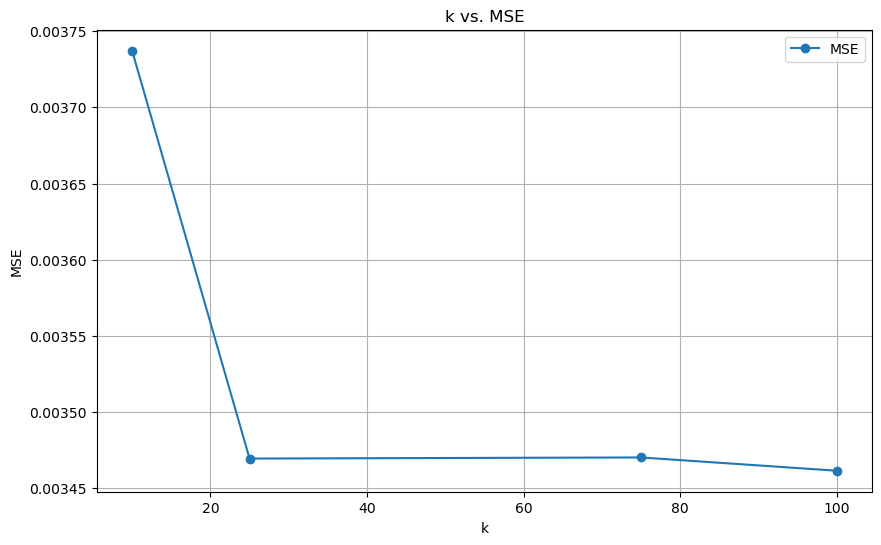

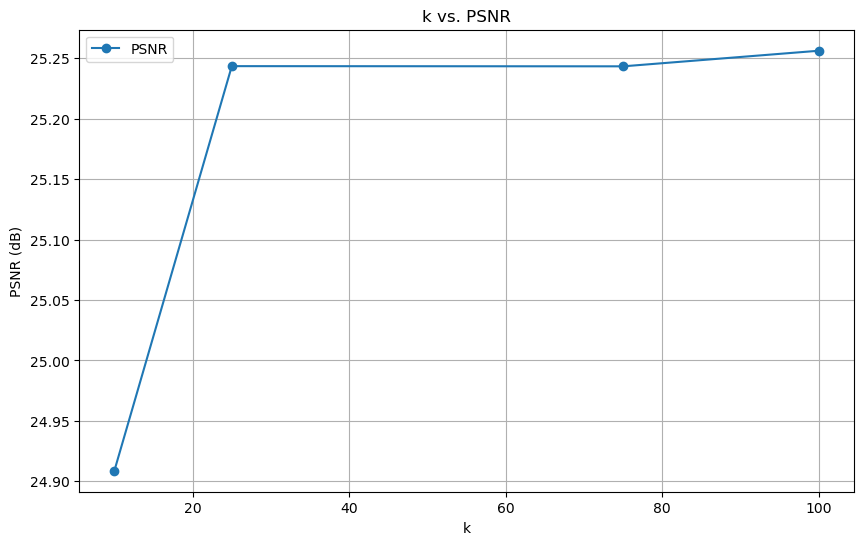

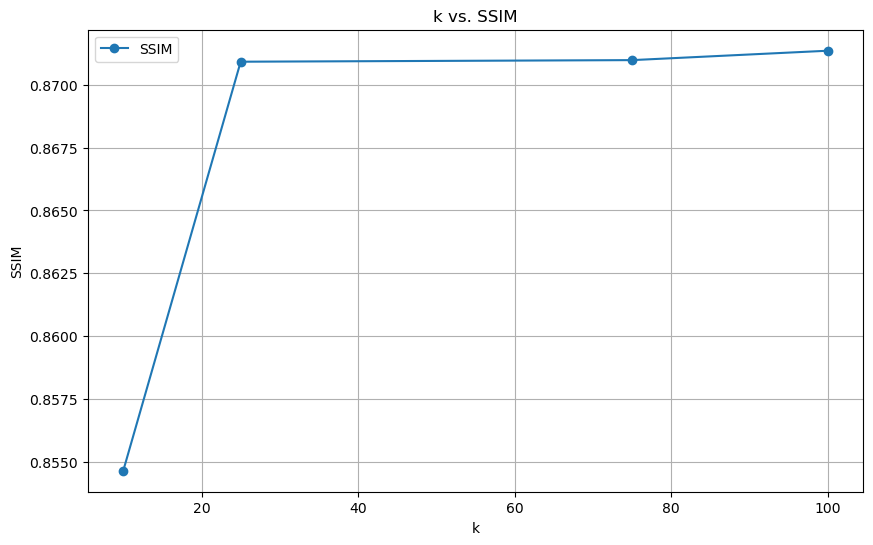

    k |    Avg MSE |   Avg PSNR |   Avg SSIM
----------------------------------------
   10 |     0.0037 |    24.9087 |     0.8546
   25 |     0.0035 |    25.2435 |     0.8709
   75 |     0.0035 |    25.2434 |     0.8710
  100 |     0.0035 |    25.2563 |     0.8714


In [4]:
'''
Parameters: k_values,num_images,noise_factor
Function  : This function performs SVD-based image denoising on a given set of noisy images and evaluates the 
            performance for different k values, and visualizes how the MSE,PSNR and SSIM change as k increases. 
Returns   : Draws plots for metrics and prints average metric values.
'''
def svd_denoising(k_values,num_images=300,noise_factor=0.1):

    global train_data
    (x_train, _), _ = cifar10.load_data()
    x_train = x_train[:num_images]
    x_train = x_train.astype('float32') / 255.0
    avg_mse = list()
    avg_psnr = list()
    avg_ssim = list()

    for k in k_values:
        mse_k = list()
        psnr_k = list()
        ssim_k = list()

        for i in x_train:
            # Adding noise to give image
            noisy_img = add_speckle_noise(i, noise_factor)

            # Applying SVD
            denoised_img = denoise_with_svd(noisy_img, k)

            # Apply Gaussian filter to reduce residual noise
            denoised_img = gaussian_filter(denoised_img, sigma=0.8)

            # Compute metrics
            mse = mean_squared_error(i.flatten(), denoised_img.flatten())
            psnr = peak_signal_noise_ratio(i, denoised_img, data_range=1.0)
            ssim = structural_similarity(
                i,
                denoised_img,
                channel_axis=-1,
                data_range=1.0,
                gaussian_weights=True,
                sigma=1.5,
                win_size=11,
            )

            mse_k.append(mse)
            psnr_k.append(psnr)
            ssim_k.append(ssim)

        avg_mse.append(np.mean(mse_k))
        avg_psnr.append(np.mean(psnr_k))
        avg_ssim.append(np.mean(ssim_k))

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, avg_mse, marker='o', label='MSE')
    plt.title("k vs. MSE")
    plt.xlabel("k")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, avg_psnr, marker='o', label='PSNR')
    plt.title("k vs. PSNR")
    plt.xlabel("k")
    plt.ylabel("PSNR (dB)")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, avg_ssim, marker='o', label='SSIM')
    plt.title("k vs. SSIM")
    plt.xlabel("k")
    plt.ylabel("SSIM")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Print results
    print(f"{'k':>5} | {'Avg MSE':>10} | {'Avg PSNR':>10} | {'Avg SSIM':>10}")
    print("-"*40)
    for i, k in enumerate(k_values):
        print(f"{k:>5} | {avg_mse[i]:>10.4f} | {avg_psnr[i]:>10.4f} | {avg_ssim[i]:>10.4f}")
    train_data = x_train

k_values = [10, 25, 75, 100]
num_images = 300
noise_factor = 0.1

svd_denoising(k_values, num_images, noise_factor)


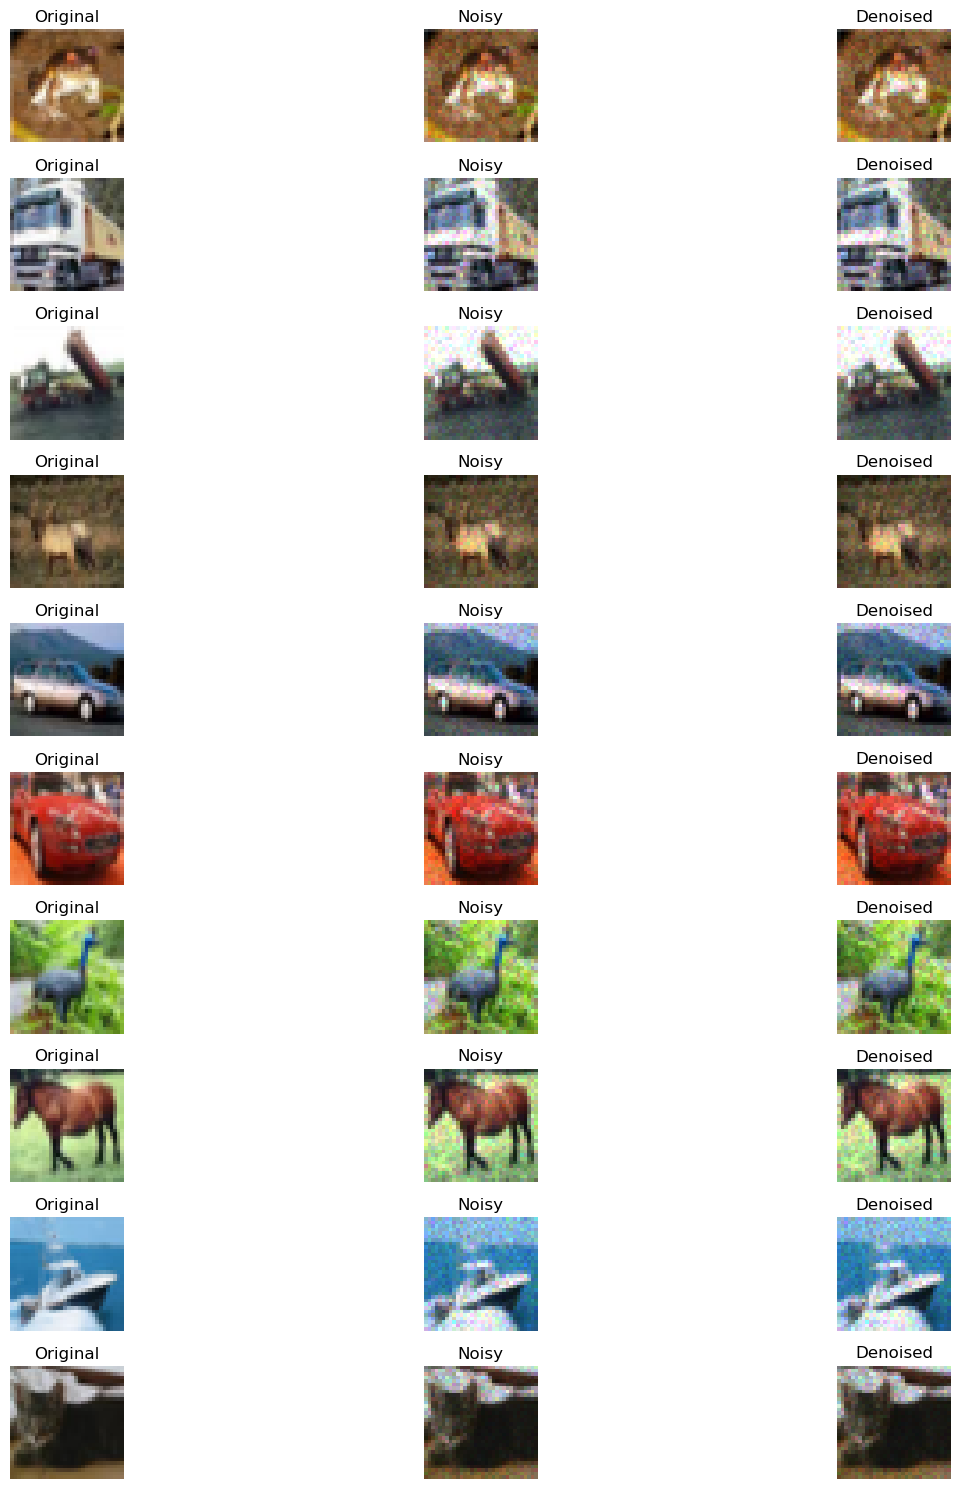

In [9]:
display_images(train_data, noise_factor, k=200)